<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Space Shuttle Reentry Using OptimalControl.jl
</div>

<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Space Shuttle Reentry Problem:* We aim find the optimal trajectory of a space shuttle reentry while minimizing the angle of attack at the terminal point.
The problem is inspired from Chapter 6 of: [Practical Methods for Optimal Control and Estimation Using Nonlinear Programming, Second Edition](https://epubs.siam.org/doi/book/10.1137/1.9780898718577).                             
We solve the problem using the [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) package in Julia.

1. [Solving with OptimalControl](#oc)
2. [Comparing with JuMP](#comp)

</div>

## 1. Solving with OptimalControl <a id='oc'></a>

1. Import the problem

In [1]:
using OptimalControl
include("../Problems/OptimalControl/space_Shuttle_OC.jl")
SpaceShuttleOC = space_Shuttle_OC()


The (autonomous) optimal control problem is given by:

    w = 203000.0
    g₀ = 32.174
    m = w / g₀
    ρ₀ = 0.002378
    hᵣ = 23800.0
    Rₑ = 2.09029e7
    μ = 1.4076539e16
    S = 2690.0
    a₀ = -0.20704
    a₁ = 0.029244
    b₀ = 0.07854
    b₁ = -0.0061592
    b₂ = 0.000621408
    c₀ = 1.0672181
    c₁ = -0.019213774
    c₂ = 0.00021286289
    c₃ = -1.0117249e-6
    h_s = 2.6
    ϕ_s = deg2rad(0)
    θ_s = deg2rad(0)
    v_s = 2.56
    γ_s = deg2rad(-1)
    ψ_s = deg2rad(90)
    α_s = deg2rad(0)
    β_s = deg2rad(0)
    t_s = 1.0
    h_t = 0.8
    v_t = 0.25
    γ_t = deg2rad(-5)
    tf = 2009.0
    t0 = 0.0
    t ∈ [t0, tf], time
    x ∈ R⁶, state
    u ∈ R², control
    scaled_h = x₁
    ϕ = x₂
    θ = x₃
    scaled_v = x₄
    γ = x₅
    ψ = x₆
    α = u₁
    β = u₂
    scaled_h(t) ≥ 0, scaled_h_con
    deg2rad(-89) ≤ θ(t) ≤ deg2rad(89), θ_con
    scaled_v(t) ≥ 0.0001, scaled_v_con
    deg2rad(-89) ≤ γ(t) ≤ deg2rad(89), γ_con
    deg2rad(-89) ≤ β(t) ≤ deg2rad(1), β_con
    


┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ❌ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


2. Initial guess

In [2]:
import Interpolations

## Initial conditions
h_s = 2.6          # altitude (ft) / 1e5
ϕ_s = deg2rad(0)   # longitude (rad)
θ_s = deg2rad(0)   # latitude (rad)
v_s = 2.56         # velocity (ft/sec) / 1e4
γ_s = deg2rad(-1)  # flight path angle (rad)
ψ_s = deg2rad(90)  # azimuth (rad)
α_s = deg2rad(0)   # angle of attack (rad)
β_s = deg2rad(0)   # bank angle (rad)
t_s = 1.00         # time step (sec)

## Final conditions, the so-called Terminal Area Energy Management (TAEM)
h_t = 0.8          # altitude (ft) / 1e5
v_t = 0.25         # velocity (ft/sec) / 1e4
γ_t = deg2rad(-5)  # flight path angle (rad)
tf = 2009.0 # final time (sec)
t0 = 0.0 # initial time (sec)
n=503

x_s = [h_s, ϕ_s, θ_s, v_s, γ_s, ψ_s, α_s, β_s]
x_t = [h_t, ϕ_s, θ_s, v_t, γ_t, ψ_s, α_s, β_s]
interp_linear = Interpolations.LinearInterpolation([1, n], [x_s, x_t])
initial_guess = mapreduce(transpose, vcat, interp_linear.(1:n))


xinit = initial_guess[:,1:6]
uinit = initial_guess[:,7:8]

init = (x_init = xinit,u_init = uinit)


(x_init = [2.6 0.0 … -0.017453292519943295 1.5707963267948966; 2.596414342629482 0.0 … -0.01759236257986316 1.5707963267948966; … ; 0.8035856573705179 0.0 … -0.08712739253979661 1.5707963267948966; 0.8 0.0 … -0.08726646259971647 1.5707963267948966], u_init = [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

3. solving the problem

In [3]:
import HSL_jll
sol = OptimalControl.solve(SpaceShuttleOC,
                            init=init,
                            grid_size = 502,
                            linear_solver="ma57",hsllib=HSL_jll.libhsl_path,
                            output_file="rocketOC.out",
                            #display=false,
                            )
# ~1m20 avec 502 points
# ~50s avec 100 points (par defaut)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    30129
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    12072

Total number of variables............................:     4024
                     variables with only lower bounds:     1006
                variables with lower and upper bounds:     2012
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3021
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 4.00e+02 1.20e+00   0.0 0.00e

CTBase.OptimalControlSolution

4. Showing the results

In [4]:
rad2deg(sol.objective)

-0.0008739269686260293

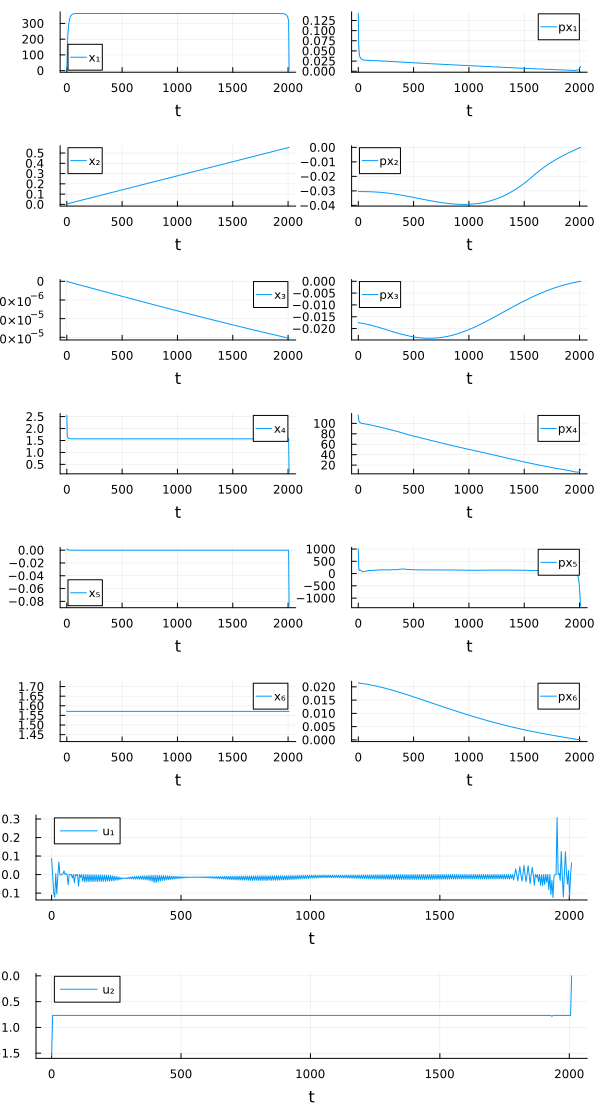

In [5]:
plot(sol)

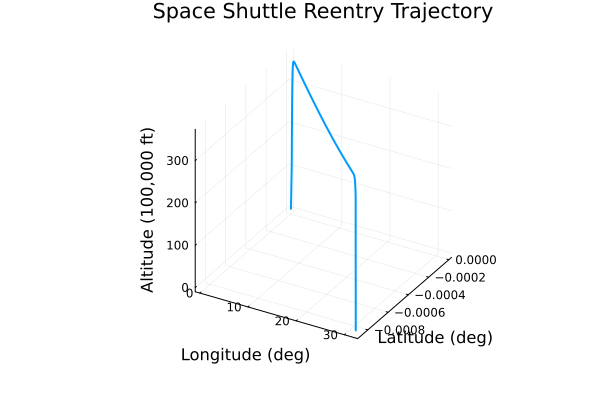

In [6]:
using JuMP
Δt = ones(n)*(tf/(n-1))
ts = cumsum([0; value.(Δt)])[1:end-1]
x = [sol.state(t) for t in ts]
scaled_h = [x[i][1] for i in 1:length(x)]
ϕ = [x[i][2] for i in 1:length(x)]
θ = [x[i][3] for i in 1:length(x)]
plot(
    rad2deg.(ϕ),
    rad2deg.(θ),
    scaled_h;
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

## 2. Comparing with JuMP <a id='comp'></a>

In [44]:
using JuMP , Ipopt
using CTBase
import HSL_jll
include("../Problems/JuMP/space_Shuttle_JMP.jl")
SpaceShuttleJMP = space_Shuttle_JMP("trapezoidal")

set_optimizer(SpaceShuttleJMP,Ipopt.Optimizer)
set_attribute(SpaceShuttleJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(SpaceShuttleJMP, "linear_solver", "ma57")
optimize!(SpaceShuttleJMP) 


This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    33141
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   179214

Total number of variables............................:     4527
                     variables with only lower bounds:     1006
                variables with lower and upper bounds:     2515
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3021
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.25e+03 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

Final latitude θ = 34.14°


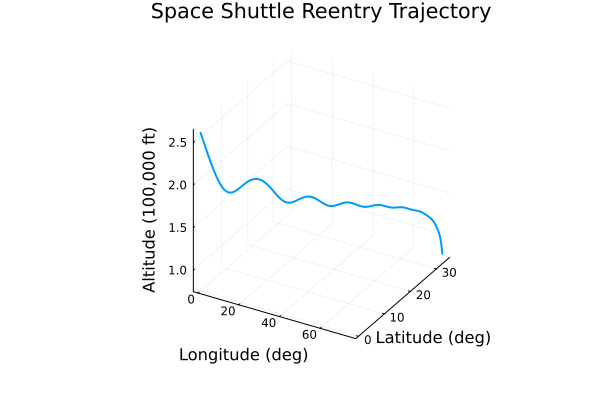

In [8]:
using Plots
println(
    "Final latitude θ = ",
    round(objective_value(SpaceShuttleJMP) |> rad2deg; digits = 2),
    "°",
)
scaled_h = SpaceShuttleJMP[:scaled_h]
ϕ = SpaceShuttleJMP[:ϕ]
θ = SpaceShuttleJMP[:θ]
plot(
    rad2deg.(value.(ϕ)),
    rad2deg.(value.(θ)),
    value.(scaled_h);
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

----------------

# Contraintes de boites  et non linéaire

In [51]:
list_of_constraint_types(SpaceShuttleJMP)

4-element Vector{Tuple{Type, Type}}:
 (NonlinearExpr, MathOptInterface.EqualTo{Float64})
 (AffExpr, MathOptInterface.EqualTo{Float64})
 (VariableRef, MathOptInterface.GreaterThan{Float64})
 (VariableRef, MathOptInterface.LessThan{Float64})

In [54]:
using MathOptInterface
cb_JMP = length(all_constraints(SpaceShuttleJMP, VariableRef, MathOptInterface.GreaterThan{Float64})) + length(all_constraints(SpaceShuttleJMP, VariableRef, MathOptInterface.LessThan{Float64}));
println("Nombre de contraintes de boite pour JuMP : ", cb_JMP)
cnl_JMP = length(all_constraints(SpaceShuttleJMP, NonlinearExpr, MathOptInterface.EqualTo{Float64})) + length(all_constraints(SpaceShuttleJMP, AffExpr, MathOptInterface.EqualTo{Float64}));


output = read("rocketOC.out", String)
ub_lb = parse(Float64,split(split(output, "                variables with lower and upper bounds:")[2], "\n")[1])
ub = parse(Float64,split(split(output, "                     variables with only upper bounds:")[2], "\n")[1])
lb = parse(Float64,split(split(output, "                     variables with only lower bounds:")[2], "\n")[1])
println("Nombre de contraintes de boite pour OC : ", Int64(ub_lb*2+ub+lb))
eq = parse(Float64,split(split(output, "Total number of equality constraints.................:")[2], "\n")[1])
ineq = parse(Float64,split(split(output, "Total number of inequality constraints...............:")[2], "\n")[1])
println("Nombre de contraintes non linéaires pour JuMP : ", cnl_JMP)
println("Nombre de contraintes non linéaires pour OC : ", Int64(eq+ineq))


Nombre de contraintes de boite pour JuMP : 6036
Nombre de contraintes de boite pour OC : 5030
Nombre de contraintes non linéaires pour JuMP : 3021
Nombre de contraintes non linéaires pour OC : 3021
